In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
module = fc.sixb.feynnet

In [4]:
use_signal = [ i for i, m in enumerate(module.full_signal_6b_list) if m in module.signal_6b_list ]

In [5]:
def use_test(f):
    return f.replace('ntuple','test_ntuple')

In [6]:
signal = ObjIter([Tree(use_test(f), report=False, ) for f in tqdm(module.full_signal_6b_list)])
bkg = ObjIter([Tree(map(use_test,module.Run2_UL18.QCD_B_List))])

100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


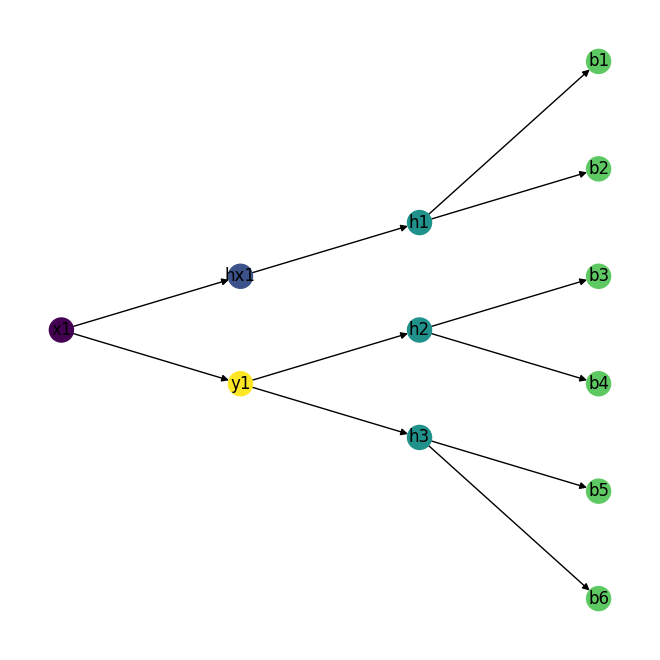

In [7]:
from utils.FeynNet.Feynman import Feynman

x_yh_3h_6b = Feynman('x').decays(
    Feynman('hx').decays(Feynman('h').decays('b','b')),
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    ),
).build_diagram()
x_yh_3h_6b.draw_diagram()

In [6]:
signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==6))

In [7]:
nfinalstates = dict(b=6)
internalstates = x_yh_3h_6b.get_internalstate_types()

jet_perms = x_yh_3h_6b.get_finalstate_permutations(**nfinalstates)['b']
h_b_perms = internalstates['h'][0].get_product_permutations(**nfinalstates)['b']
hx_h_perms = internalstates['hx'][0].get_product_permutations(**nfinalstates)['h']
y_h_perms = internalstates['y'][0].get_product_permutations(**nfinalstates)['h']
x_yhx_perms = internalstates['x'][0].get_product_permutations(**nfinalstates)
x_y_perms = x_yhx_perms['y']
x_hx_perms = x_yhx_perms['hx']

In [8]:
def get_reco(jet_p4, perm):
    if perm.ndim == 1:
        p4 = jet_p4[:, perm]
    else:
        p4 = jet_p4[perm]
        
    h_p4 = p4[:,::2] + p4[:,1::2]
    hx_p4, hy_p4 = h_p4[:,0], h_p4[:,1:]
    y_p4 = h_p4[:,1] + h_p4[:,2]
    x_p4 = y_p4 + hx_p4

    hy_p4_ordered = hy_p4[ak.argsort(hy_p4.pt, axis=1, ascending=True)]

    return x_p4, y_p4, hx_p4, hy_p4_ordered

In [9]:
jet_p4 = build_p4(signal[0], 'jet')

In [10]:
def get_best_perm(jet_p4):
    b_perms = jet_p4[:,h_b_perms]
    h_p4 = b_perms[:,:,0] + b_perms[:,:,1]
    h_hx_perms = h_p4[:, hx_h_perms]
    h_y_perms = h_p4[:, y_h_perms]
    hx_p4 = h_hx_perms[:,:,0]
    y_p4 = h_y_perms[:,:,0] + h_y_perms[:,:,1]
    hx_x_perms = hx_p4[:, x_hx_perms]
    y_x_perms = y_p4[:, x_y_perms]
    x_p4 = hx_x_perms[:,:,0] + y_x_perms[:,:,0]
    
    x_3h_m = ak.flatten( ak.concatenate([hx_x_perms[:,:,None], h_y_perms[:, x_y_perms]], axis=2), axis=3).m
    x_y_m = y_x_perms.m
    # m_chi2 = (x_m/1000-1)**2 + ak.mean( (x_2y_m/450 - 1)**2, axis=2) + ak.mean( (x_4h_m/125 - 1)**2, axis=2)
    # m_chi2 = ak.mean( (x_2y_m/450 - 1)**2, axis=2) + ak.mean( (x_4h_m/125 - 1)**2, axis=2)
    m_chi2 =  ak.sum( (x_3h_m/125 - 1)**2, axis=2)

    my_chi2 = ak.concatenate([
        (x_y_m/my-1)**2
        for my in (400,600,1000)
    ], axis=2)

    m_chi2 = m_chi2 + ak.min(my_chi2, axis=2)

    reco_rank = ak.min(m_chi2, axis=1)
    best_perms = jet_perms[ak.argmin( m_chi2, axis=1)]

    return ak.from_regular(best_perms), reco_rank

In [11]:
def mass_fit_reco(t):
    jet_p4 = build_p4(t, 'jet', use_regressed=True, extra=['signalId'])

    best_perm, reco_rank = get_best_perm(jet_p4)
    x_p4, y_p4, hx_p4, hy_p4 = get_reco(jet_p4, best_perm)

    t.extend(
        reco_rank=reco_rank,
        X_m=x_p4.m,
        Y_m=y_p4.m,
        HX_m=hx_p4.m,
        H1_m=hy_p4.m[:,0],
        H2_m=hy_p4.m[:,1],
    )

In [12]:
(signal+bkg).apply(mass_fit_reco, report=True)

100%|██████████| 4/4 [01:08<00:00, 17.03s/it]


[None, None, None, None]

100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


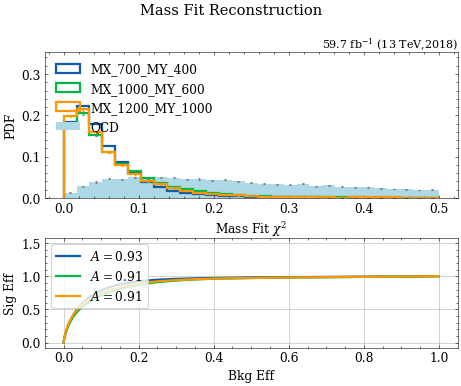

In [13]:
study.quick(
    signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['reco_rank'],
    binlist=[(0,0.5,30)],
    xlabels=['Mass Fit $\chi^2$'],
    suptitle='Mass Fit Reconstruction',
    efficiency=True,

    **study.auroc,
)

In [14]:
varinfo.X_m = dict(bins=(400, 2000, 30))
varinfo.Y_m=dict(bins=(200,1500,30))
varinfo.HX_m = dict(bins=(0,500,30))
varinfo.H1_m = dict(bins=(0,500,30))
varinfo.H2_m = dict(bins=(0,500,30))


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


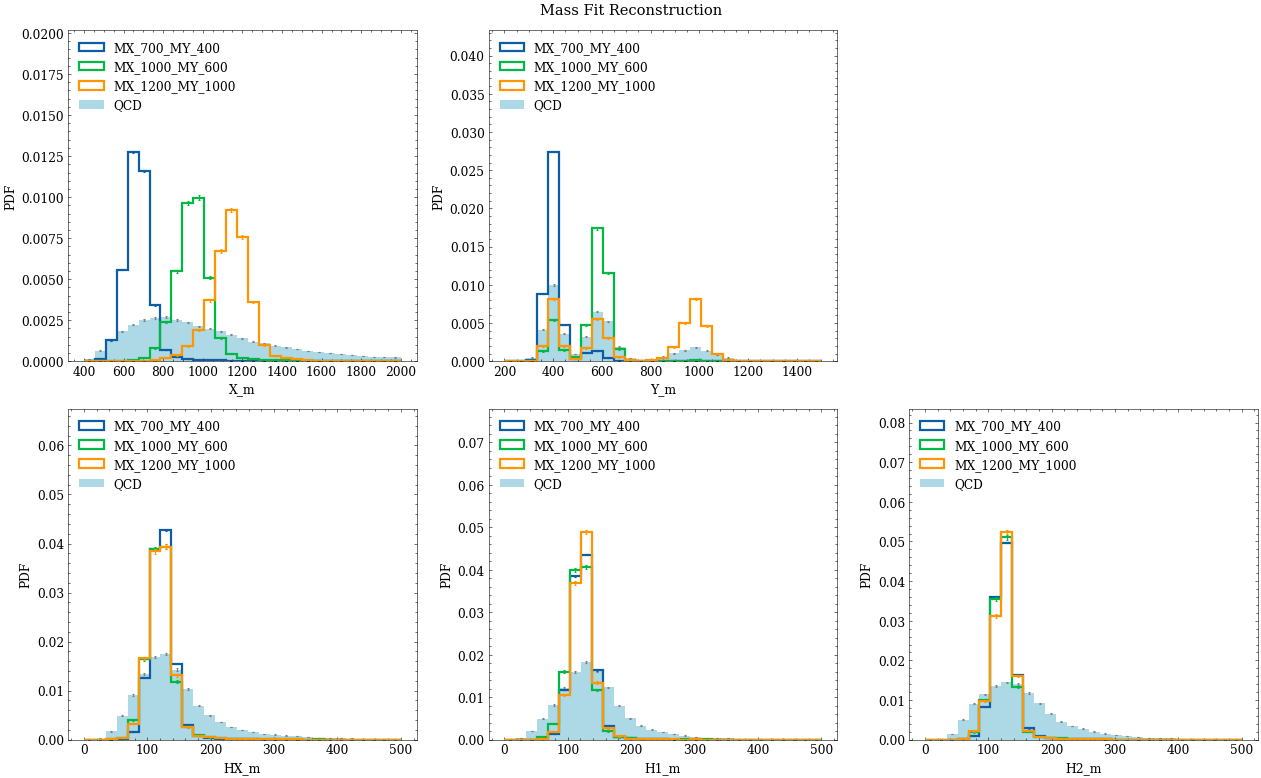

In [15]:
study.quick(
    signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y_m',None,'HX_m','H1_m','H2_m'],
    suptitle='Mass Fit Reconstruction',
    lumi=None,
    density=True,
)